In [49]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import keras.backend as K

In [41]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 2000000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [18]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
f = open('../glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM , encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [19]:
train = pd.read_csv("./toxic_comment_train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [34]:

len(train)

159571

In [36]:

len(targets)

159571

In [121]:
from keras.preprocessing.text import Tokenizer

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [23]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


Found 210337 unique tokens.


In [24]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [37]:
train_x , valid_x = data[:140000], data[140000:]
train_y, valid_y = targets[:140000], targets[140000:]

In [42]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [43]:
embedding_matrix.shape

(210338, 50)

In [44]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [45]:

print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

Building model...


In [46]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

In [47]:

print('Training model...')
r = model.fit(
  train_x,
  train_y,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(valid_x, valid_y)
)


Training model...
Epoch 1/5
1094/1094 [==============================] - 60s 51ms/step - loss: 0.0876 - accuracy: 0.9789 - val_loss: 0.0607 - val_accuracy: 0.9942
Epoch 2/5
1094/1094 [==============================] - 54s 49ms/step - loss: 0.0576 - accuracy: 0.9877 - val_loss: 0.0579 - val_accuracy: 0.9836
Epoch 3/5
1094/1094 [==============================] - 54s 49ms/step - loss: 0.0550 - accuracy: 0.9855 - val_loss: 0.0557 - val_accuracy: 0.9852
Epoch 4/5
1094/1094 [==============================] - 54s 49ms/step - loss: 0.0533 - accuracy: 0.9744 - val_loss: 0.0549 - val_accuracy: 0.9763
Epoch 5/5
1094/1094 [==============================] - 54s 49ms/step - loss: 0.0523 - accuracy: 0.9779 - val_loss: 0.0548 - val_accuracy: 0.9876


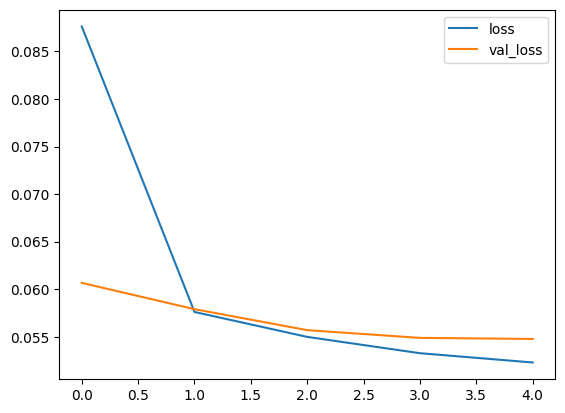

In [50]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

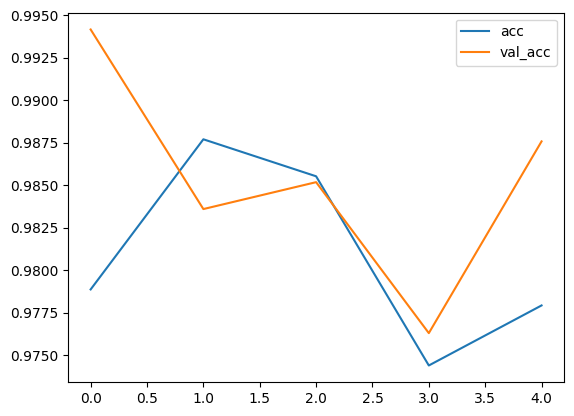

In [51]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [52]:
 p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 [==============================] - 61s 12ms/step
0.9748646778377772
